In [1]:
import pandas as pd
import numpy as np

def get_data(file):
    data = pd.read_csv(file, sep='\t', skiprows=2, index_col=0)
    data = data.drop(['Description'], axis=1)
    return data

counts = get_data('../data/counts.gct')
counts = counts[np.all(counts != 0, axis=1)]

rpkm = get_data('../data/rpkms.gct')
rpkm = rpkm.loc[counts.index]

meta = pd.read_csv('../data/meta.txt', sep='\t', skiprows=31, index_col=0)
meta.shape

(44, 57)

In [2]:
import scipy.stats as stats

def normalize(data):
    means = stats.mstats.gmean(data, axis=1)
    ratios = data / np.tile(means, (len(data.columns), 1)).T
    medians = np.median(ratios, axis=0)
    return data / np.tile(medians, (len(data), 1))

normal = normalize(counts)
normal.shape

(4297, 57)

In [3]:
def log(x):
    return np.log2(x + 1)

dmso = meta.columns[meta.loc['!Sample_source_name_ch1'] == 'DMSO']

dfs = [normal, rpkm, counts]
data = [log(np.array(i[dmso].T)) for i in dfs]
data = np.concatenate(data).T
data.shape

(4297, 18)

/Users/albertwang/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


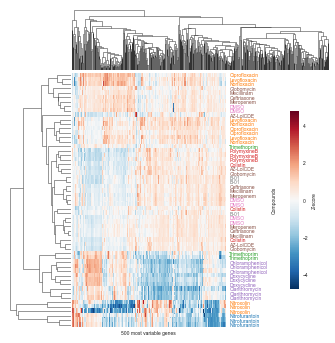

In [5]:
import copy
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', rc={'font.sans-serif':'Arial'})

data = copy.deepcopy(normal)
meta1 = '"PDD_P2_18"	"PDD_P2_44"	"PDD_P2_70"	"PDD_P2_20"	"PDD_P2_46"	"PDD_P2_72"	"PDD_P2_11"	"PDD_P2_37"	"PDD_P2_63"	"PDD_P2_05"	"PDD_P2_31"	"PDD_P2_57"	"PDD_P2_21"	"PDD_P2_47"	"PDD_P2_73"	"PDD_P2_07"	"PDD_P2_33"	"PDD_P2_59"	"PDD_P2_15"	"PDD_P2_41"	"PDD_P2_67"	"PDD_P2_01"	"PDD_P2_02"	"PDD_P2_27"	"PDD_P2_28"	"PDD_P2_53"	"PDD_P2_54"	"PDD_P2_09"	"PDD_P2_35"	"PDD_P2_61"	"PDD_P2_23"	"PDD_P2_49"	"PDD_P2_75"	"PDD_P2_10"	"PDD_P2_36"	"PDD_P2_62"	"PDD_P2_14"	"PDD_P2_40"	"PDD_P2_66"	"PDD_P2_04"	"PDD_P2_30"	"PDD_P2_56"	"PDD_P2_03"	"PDD_P2_29"	"PDD_P2_55"	"PDD_P2_06"	"PDD_P2_32"	"PDD_P2_58"	"PDD_P2_24"	"PDD_P2_50"	"PDD_P2_76"	"PDD_P2_12"	"PDD_P2_38"	"PDD_P2_64"	"PDD_P2_26"	"PDD_P2_52"	"PDD_P2_78"'
meta1 = meta1.replace('"', ' ').split('\t')
names = 'AZ-LolCDE AZ-LolCDE AZ-LolCDE B-01 B-01 B-01 Ceftriaxone Ceftriaxone Ceftriaxone Chloramphenicol Chloramphenicol Chloramphenicol Ciprofloxacin Ciprofloxacin Ciprofloxacin Clarithromycin Clarithromycin Clarithromycin Colistin Colistin Colistin DMSO DMSO DMSO DMSO DMSO DMSO Doxycycline Doxycycline Doxycycline Globomycin Globomycin Globomycin Levofloxacin Levofloxacin Levofloxacin Mecillinam Mecillinam Mecillinam Meropenem Meropenem Meropenem Nitrofurantoin Nitrofurantoin Nitrofurantoin Nitroxolin Nitroxolin Nitroxolin Norfloxacin Norfloxacin Norfloxacin PolymyxineB PolymyxineB PolymyxineB Trimethoprim Trimethoprim Trimethoprim'
names = names.split(' ')

data.columns = np.array(names)[np.argsort(meta1)]

var = np.argsort(np.var(data, axis=1))
to_plot = var >= len(data) - 500
data = data.loc[to_plot]

moa_line = 10
moas = sorted(list(set([i[5:].split(' / ')[0] for i in meta.iloc[10]])))
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Clusters each condition by euclidean distance. Please see
# https://seaborn.pydata.org/generated/seaborn.clustermap.html
# for more documentation
h = sns.clustermap(log(data).T, z_score=1, figsize=(5, 5), cmap='RdBu_r', yticklabels=True, xticklabels=False,
                   cbar_kws={'pad': 0.25, 'shrink': 0.7, 'label': 'Z-score'},
                   center=0, cbar_pos=None, cbar=True)
h.ax_heatmap.figure.axes[-1].yaxis.label.set_size(5)

for i in range(len(data.columns)):
    name = plt.gca().get_yticklabels()[i].get_text()
    mech = meta[meta.columns[np.argsort(np.any(meta == name, axis=0))[-1]]].iloc[moa_line][5:].split(' / ')[0]
    plt.gca().get_yticklabels()[i].set_color(color[moas.index(mech)])

# Removes all tick lines in the figure
for i in range(len(h.fig.axes)):
    h.fig.axes[i].tick_params(size=0, labelsize=5)

plt.ylabel('Compounds', fontsize=5)    
plt.xlabel('%d most variable genes' % len(data), fontsize=5)  

# Saves figure to as clustermap_test.png
plt.savefig('../figs/heatmap1.png', dpi=300)
plt.show()

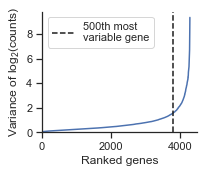

In [6]:
plt.figure(figsize=(3, 2.5))
plt.plot(np.sort(np.var(log(normal), axis=1)))
plt.axvline(len(normal)-500, c='k', linestyle='--', label='500th most\nvariable gene')
sns.despine()
plt.ylabel('Variance of log$_\mathregular{2}$(counts)')
plt.xlim(0,)
plt.ylim(0,)
plt.xlabel('Ranked genes')
plt.legend()
plt.tight_layout()
plt.savefig('../figs/heatmap2.png', dpi=300)

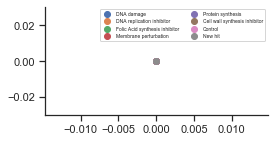

In [8]:
plt.figure(figsize=(4, 2))

for i in moas:
    plt.scatter([0], [0], label=i[0].upper() + i[1:])
plt.legend(ncol=2, fontsize=5)
sns.despine()
plt.savefig('../figs/heatmap3.png', dpi=300)
plt.show()